In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 165

ng =4

ng_refs = (/ 2 , 2 /) 

nref =2

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 500 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 1215

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.6 , 0.6 , 0.7 , 0.9/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

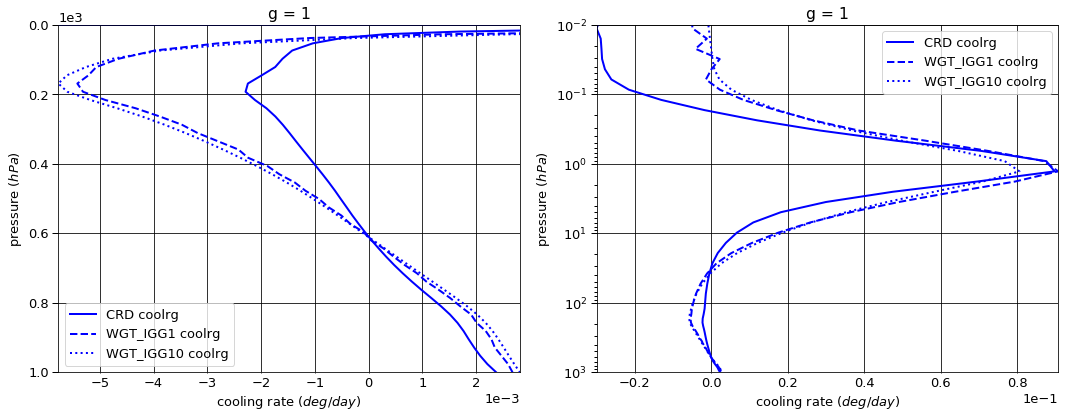

# Figure: cooling rate g-group 2

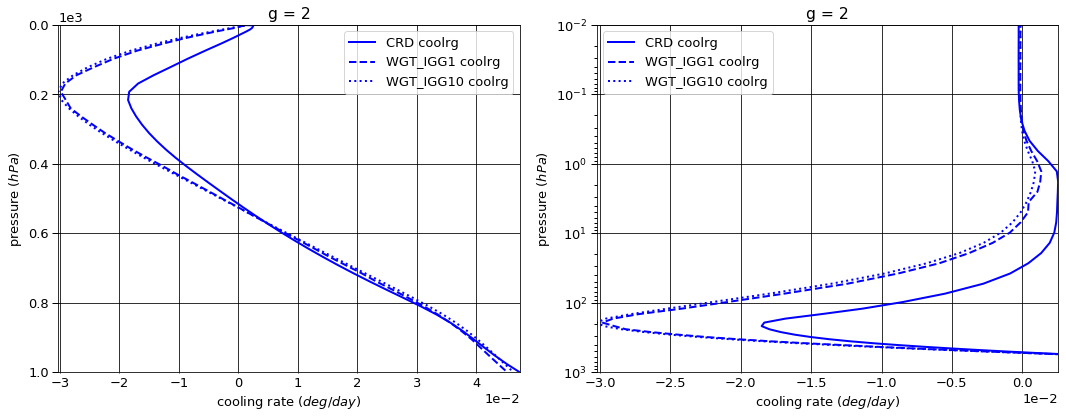

# Figure: cooling rate g-group 3

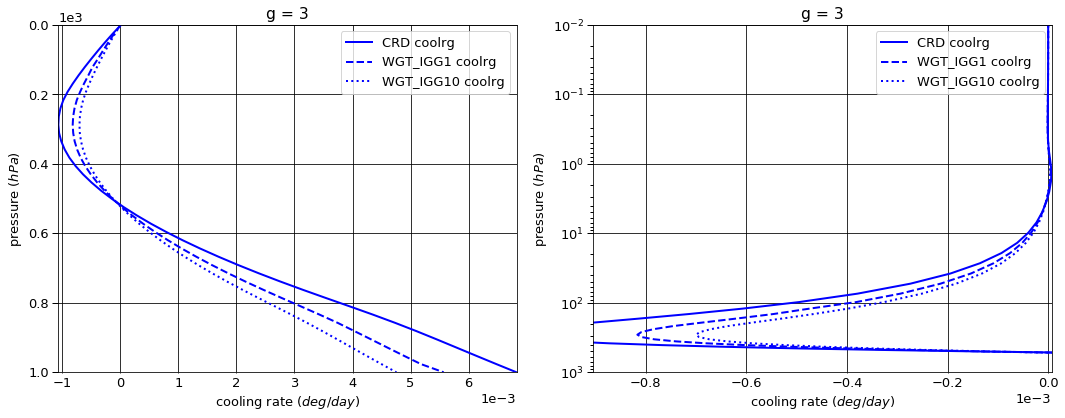

# Figure: cooling rate g-group 4

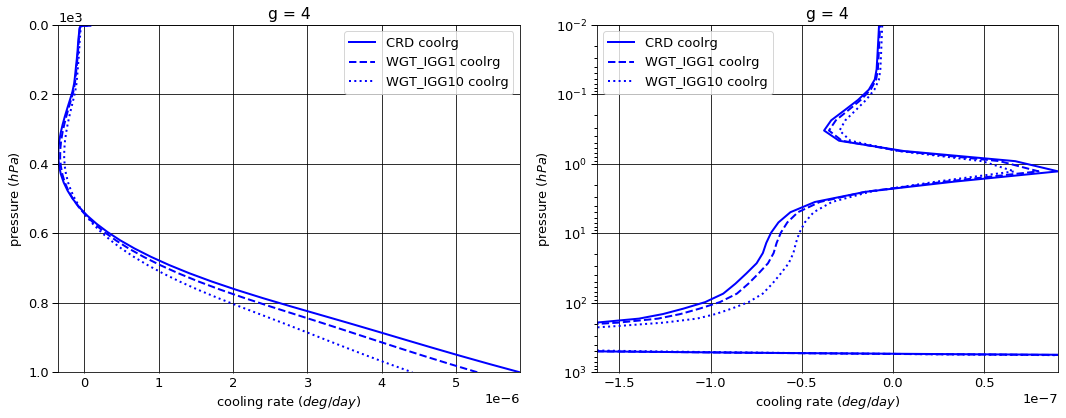

# Figure: cooling rate g-group total

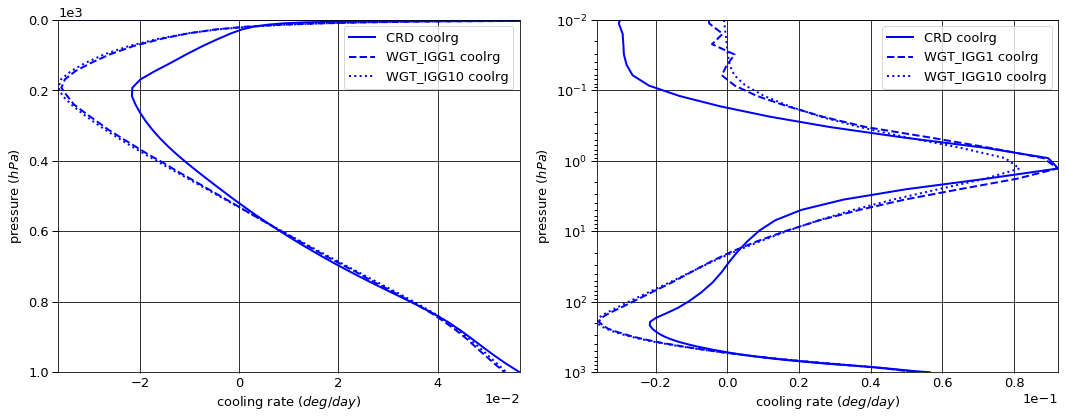

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.214389  0.000000 -0.214389
  1013.0   76    -0.448203  0.248268 -0.199935
2 0.0      1     -6.896357  0.000000 -6.896357
  1013.0   76    -9.392867  3.328108 -6.064759
3 0.0      1     -8.664874  0.000000 -8.664874
  1013.0   76    -8.814777  0.301389 -8.513388
4 0.0      1     -5.099260  0.000000 -5.099260
  1013.0   76    -5.099328  0.000195 -5.099133


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.100882  0.000000 -0.100882
  1013.0   76    -0.448203  0.292490 -0.155713
2 0.0      1     -6.623863  0.000000 -6.623863
  1013.0   76    -9.392867  3.139791 -6.253076
3 0.0      1     -8.702971  0.000000 -8.702971
  1013.0   76    -8.814777  0.232230 -8.582547
4 0.0      1     -5.099266  0.000000 -5.099266
  1013.0   76    -5.099328  0.000176 -5.099152


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.091234  0.000000 -0.091234
  1013.0   76    -0.448203  0.298229 -0.149974
2 0.0      1     -6.699318  0.000000 -6.699318
  1013.0   76    -9.392867  3.067925 -6.324942
3 0.0      1     -8.719986  0.000000 -8.719986
  1013.0   76    -8.814777  0.198166 -8.616611
4 0.0      1     -5.099276  0.000000 -5.099276
  1013.0   76    -5.099328  0.000147 -5.099181


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.135071e-01  0.000000  0.113507
  1013.0   76     0.000000e+00  0.044222  0.044222
2 0.0      1      2.724936e-01  0.000000  0.272494
  1013.0   76     0.000000e+00 -0.188317 -0.188317
3 0.0      1     -3.809750e-02  0.000000 -0.038098
  1013.0   76     0.000000e+00 -0.069159 -0.069159
4 0.0      1     -5.700000e-06  0.000000 -0.000006
  1013.0   76     8.881784e-16 -0.000019 -0.000019


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.231545e-01  0.000000  0.123154
  1013.0   76     0.000000e+00  0.049961  0.049961
2 0.0      1      1.970382e-01  0.000000  0.197038
  1013.0   76     0.000000e+00 -0.260183 -0.260183
3 0.0      1     -5.511270e-02  0.000000 -0.055113
  1013.0   76     0.000000e+00 -0.103223 -0.103222
4 0.0      1     -1.590000e-05  0.000000 -0.000016
  1013.0   76     8.881784e-16 -0.000048 -0.000048

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.272685e-02
  1001.112500 75     2.371315e-03
2 0.000312    1     -2.462212e-04
  1001.112500 75     4.736695e-02
3 0.000312    1     -6.813425e-08
  1001.112500 75     6.823054e-03
4 0.000312    1     -5.643831e-09
  1001.112500 75     5.857457e-06


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -7.727271e-03
  1001.112500 75     2.675212e-03
2 0.000312    1     -1.214913e-04
  1001.112500 75     4.525325e-02
3 0.000312    1     -6.837442e-08
  1001.112500 75     5.569604e-03
4 0.000312    1     -5.187522e-09
  1001.112500 75     5.287117e-06


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -3.049061e-03
  1001.112500 75     2.811178e-03
2 0.000312    1     -1.295772e-04
  1001.112500 75     4.630583e-02
3 0.000312    1     -5.828757e-08
  1001.112500 75     4.755815e-03
4 0.000312    1     -4.346951e-09
  1001.112500 75     4.410565e-06


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.499958e-02
  1001.112500 75     3.038967e-04
2 0.000312    1      1.247299e-04
  1001.112500 75    -2.113700e-03
3 0.000312    1     -2.401630e-10
  1001.112500 75    -1.253450e-03
4 0.000312    1      4.563098e-10
  1001.112500 75    -5.703400e-07


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.967779e-02
  1001.112500 75     4.398634e-04
2 0.000312    1      1.166440e-04
  1001.112500 75    -1.061126e-03
3 0.000312    1      9.846685e-09
  1001.112500 75    -2.067238e-03
4 0.000312    1      1.296880e-09
  1001.112500 75    -1.446892e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.874879,0.00000,-20.874879
1013.0,76,-23.755176,3.87796,-19.877215



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.526982,0.000000,-20.526982
1013.0,76,-23.755176,3.664687,-20.090489



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.609815,0.000000,-20.609815
1013.0,76,-23.755176,3.564467,-20.190708



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.347898,0.000000,0.347898
1013.0,76,0.000000,-0.213273,-0.213273



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.265064,0.000000,0.265064
1013.0,76,0.000000,-0.313493,-0.313493


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.032973
1001.112500,75,0.056567



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.007849
1001.112500,75,0.053503



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.003179
1001.112500,75,0.053877



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.025124
1001.112500,75,-0.003064



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.029794
1001.112500,75,-0.002690


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.018333,0.018991
2,0.383303,0.398345
3,0.344545,0.380108
4,0.253818,0.202555


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.622268e-20
2,5.156498e-23
3,2.344636e-23
4,2.164750e-26


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.622268e-20,NaN,0.018333,0.018991,0.018333,0.018991,1.0
2,5.156498e-23,0.000917,0.383303,0.398345,0.401636,0.417336,1.0
3,2.344636e-23,0.454695,0.344545,0.380108,0.746182,0.797445,500.0
4,2.164750e-26,0.000923,0.253818,0.202555,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog       ratio        taulyr
layer g pressure                                                         
1     1 0.000312     2.826949e-18  5.482133e-20   51.566596  7.280189e-06
      2 0.000312     4.321569e-22  9.988959e-24   43.263459  1.115652e-09
      3 0.000312     8.688713e-26  7.991783e-26    1.087206  3.593121e-13
      4 0.000312     1.152046e-26  3.225872e-28   35.712706  4.407134e-14
2     1 0.000750     2.827389e-18  5.497029e-20   51.434859  2.932915e-06
      2 0.000750     4.344397e-22  1.045430e-23   41.556073  4.520250e-10
      3 0.000750     9.129863e-26  8.415927e-26    1.084832  1.521684e-13
      4 0.000750     1.173263e-26  3.245719e-28   36.148027  1.807760e-14
3     1 0.001052     2.828313e-18  5.523596e-20   51.204202  4.114660e-06
      2 0.001052     4.385674e-22  1.079015e-23   40.645165  6.401628e-10
      3 0.001052     9.611654e-26  8.861739e-26    1.084624  2.246722e-13
      4 0.001052     1.219278e-26  3.273337e-28   37.248786  2.634367e-14
4     1 0.001476     2.829297e-18  5.552878e-20   50.951900  5.774798e-06
      2 0.001476     4.431230e-22  1.121175e-23   39.523090  9.078238e-10
      3 0.001476     1.020885e-25  9.418943e-26    1.083864  3.348409e-13
      4 0.001476     1.269928e-26  3.305787e-28   38.415286  3.848907e-14
5     1 0.002070     2.830287e-18  5.583942e-20   50.686187  8.103041e-06
      2 0.002070     4.479515e-22  1.173015e-23   38.188059  1.287923e-09
      3 0.002070     1.094474e-25  1.011258e-25    1.082290  5.037047e-13
      4 0.002070     1.322721e-26  3.343342e-28   39.562849  5.622379e-14
6     1 0.002904     2.831285e-18  5.617424e-20   50.401842  1.137128e-05
      2 0.002904     4.531331e-22  1.236307e-23   36.652140  1.828830e-09
      3 0.002904     1.187244e-25  1.099545e-25    1.079760  7.669650e-13
      4 0.002904     1.377727e-26  3.388197e-28   40.662543  8.214074e-14
7     1 0.004074     2.832292e-18  5.654242e-20   50.091454  1.595830e-05
      2 0.004074     4.587849e-22  1.313221e-23   34.935851  2.599711e-09
      3 0.004074     1.306709e-25  1.214208e-25    1.076183  1.185255e-12
      4 0.004074     1.435078e-26  3.443498e-28   41.675006  1.200134e-13
8     1 0.005714     2.833310e-18  5.695669e-20   49.744988  2.239448e-05
      2 0.005714     4.650711e-22  1.406537e-23   33.064975  3.700445e-09
      3 0.005714     1.463442e-25  1.365702e-25    1.071568  1.864231e-12
      4 0.005714     1.494935e-26  3.513681e-28   42.546105  1.753523e-13
9     1 0.008015     2.834342e-18  5.743469e-20   49.348945  3.142784e-05
      2 0.008015     4.722222e-22  1.519818e-23   31.070976  5.277166e-09
      3 0.008015     1.672337e-25  1.568695e-25    1.066069  2.992655e-12
      4 0.008015     1.557505e-26  3.604967e-28   43.204419  2.562541e-13
10    1 0.011243     2.835391e-18  5.800055e-20   48.885593  4.410556e-05
      2 0.011243     4.805591e-22  1.657481e-23   28.993334  7.544275e-09
      3 0.011243     1.954358e-25  1.843703e-25    1.060017  4.913719e-12
      4 0.011243     1.623028e-26  3.725984e-28   43.559721  3.745600e-13
11    1 0.015771     2.836464e-18  5.868708e-20   48.332003  6.190056e-05
      2 0.015771     4.905320e-22  1.824932e-23   26.879466  1.082119e-08
      3 0.015771     2.339036e-25  2.219382e-25    1.053913  8.262981e-12
      4 0.015771     1.691816e-26  3.888573e-28   43.507378  5.476711e-13
12    1 0.022122     2.837568e-18  5.953854e-20   47.659348  8.687892e-05
      2 0.022122     5.027746e-22  2.028824e-23   24.781586  1.558969e-08
      3 0.022122     2.868001e-25  2.735619e-25    1.048392  1.423336e-11
      4 0.022122     1.764323e-26  4.108745e-28   42.940671  8.011739e-13
13    1 0.031031     2.838714e-18  6.061337e-20   46.833131  1.219451e-04
      2 0.031031     5.181758e-22  2.277390e-23   22.753049  2.259036e-08
      3 0.031031     3.599913e-25  3.447647e-25    1.044165  2.508989e-11
      4 0.031031     1.841170e-26  4.407734e-28   41.771344  1.172851e-12
14    1 0.043528     2.839981e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
